# Gradient Descent

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

## Sum of squares

In [2]:
def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)

Here's what the sum of squares function looks like in a nifty 3D plot. It's easy to guess that its global minimum is at the origin.

In [3]:
n=10
X = np.linspace(-6, 6, num=n)
Y = np.linspace(-6, 6, num=n)
U, V = np.meshgrid(X, Y)

In [4]:
Z = sum_of_squares((U,V))

Text(0.5, 0, 'z')

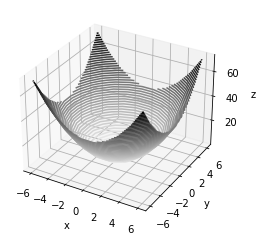

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

## Estimating the gradient

In [6]:
def partial_difference_quotient(f, v, i, epsilon=0.00001):
    """
    estimate partial derivative with respect to v_i of a function f at v
    """
    v0 = [(v_j-epsilon) if j==i else v_j for j, v_j in enumerate(v)]
    v1 = [(v_j+epsilon) if j==i else v_j for j, v_j in enumerate(v)]
    return (f(v1) - f(v0)) / (2*epsilon)

In [7]:
def estimate_gradient(f, v, epsilon=0.00001):
    return [partial_difference_quotient(f, v, i, epsilon) for i, _ in enumerate(v)]

In [8]:
estimate_gradient(sum_of_squares, (0.3, 0.3))

[0.6000000000006, 0.6000000000006]

As expected, the negative of the gradient points down hill towards the origin. The sides of the bowl get quickly steeper and thus the gradient larger as you get further away from the minimum.

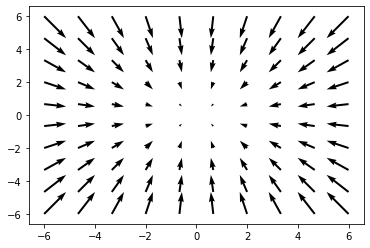

In [9]:
plt.quiver(X, Y,
           -partial_difference_quotient(sum_of_squares, (U,V), 0),
           -partial_difference_quotient(sum_of_squares, (U,V), 1))
plt.show()

## Gradient descent

Find the minimum by following the gradient.

In [10]:
def step(v, direction, step_size):
    """
    move step_size in the direction from v
    """
    return [v_i + step_size * direction_i for v_i, direction_i in zip(v, direction)]

In [11]:
def distance(v, w):
    return math.sqrt(sum((vi-wi)**2 for vi, wi in zip(v,w)))

In [12]:
tolerance = 0.0000001

In [13]:
v = [random.randint(-10,10) for i in range(3)]

In [14]:
print(v)

[0, -9, -5]


In [15]:
err = []
while True:
    err.append(sum_of_squares(v))
    gradient = estimate_gradient(sum_of_squares, v)
    next_v = step(v, gradient, -0.001)
    if distance(next_v, v) < tolerance:
        break
    v = next_v

Hey, we found zero... well, pretty close.

In [16]:
v

[0.0, -4.3662727134495834e-05, -2.4257070629755145e-05]

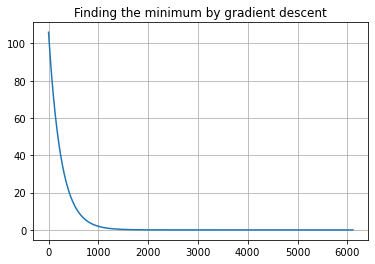

In [17]:
plt.plot(err)
plt.title('Finding the minimum by gradient descent')
plt.grid(True)
plt.show()

## Turning that into a function

In [18]:
def safe(f):
    """
    return a new function that's the same as f, except that it outputs
    infinity whenever f produces an error
    """
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')
    return safe_f

In [19]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""
    
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    theta = theta_0
    target_fn = safe(target_fn)
    value = target_fn(theta)
    values = []
    
    # set theta to initial value
    # safe version of target_fn
    # value we're minimizing
    while True:
        values.append(value)
        gradient = gradient_fn(theta)
        next_thetas = [np.array(step(theta, gradient, -step_size))
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            values.append(next_value)
            break
        else:
            theta, value = next_theta, next_value

    return theta, values

In [20]:
def est_gradient_sum_of_squares(v):
    return estimate_gradient(sum_of_squares, v)

In [21]:
n = 3
theta, values = minimize_batch(sum_of_squares,
                               est_gradient_sum_of_squares,
                               [random.randint(-10,10) for i in range(n)])

In [22]:
theta

array([ 0.00119631,  0.00066461, -0.00026585])

In [23]:
sum_of_squares(theta)

1.943531771327696e-06

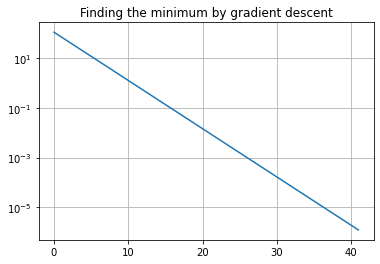

In [24]:
plt.semilogy(values)
plt.title('Finding the minimum by gradient descent')
plt.grid(True)
plt.show()

## Stochastic gradient descent

In [25]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    # create a list of indexes
    indexes = [i for i, _ in enumerate(data)]
    random.shuffle(indexes)

    # return the data in that order
    for i in indexes:
        yield data[i]

In [26]:
print(list(in_random_order(range(20))))

[3, 1, 17, 7, 15, 5, 4, 16, 0, 19, 9, 12, 10, 11, 18, 13, 6, 14, 8, 2]


In [27]:
def vector_subtract(v, w):
    """subtracts corresponding elements"""
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def scalar_multiply(c, v):
    """c is a number, v is a vector"""
    return [c * v_i for v_i in v]

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = list(zip(x, y))
    
    # initial guess
    theta = theta_0
    
    # initial step size
    alpha = alpha_0
    
    # the minimum so far
    min_theta, min_value = None, float("inf")
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

### Example

The book defines this function on page 100 in Chapter 8, then doesn't use it until page 176 in Chapter 14 on linear regression. My attention span is way too low to wait that long. Let's try this thing.

We'll start with an equation of the form $y = \theta_0 + \theta_1 x + \theta_2 x^{2}$ then add some noise, just so it's not too easy.

In [28]:
n = 1000
x = np.random.uniform(-2.0, 2.0, n)
x_org = x
y = 2.0 * x * x + 1.23456 * x + 4.5678 + np.random.normal(0.0, 1.0, n)
y_org = y

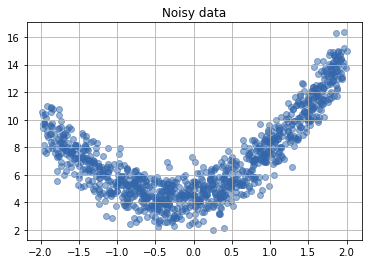

In [29]:
plt.scatter(x, y, marker='o', color='#3366aa80')
plt.title('Noisy data')
plt.grid(True)
plt.show()

In [30]:
def poly_coeff(x,y,poly_deg):

    # Matrix Size: Degree of Polynomial
#     poly_deg = 2
    mat_size = poly_deg + 1

    # Create dummy matrix
    a = np.ones((mat_size,mat_size))
    b = np.ones((mat_size,1))

    actual_x = x
#     x = x_org
#     y = y_org

    # Normalize input array
    # Mean
    meanX = np.mean(x, axis=0)
    # meanY = np.mean(y_Jan, axis=0)
    # Standard Deviation
    stdX = np.std(x, axis = 0)
    x = (x- meanX) / stdX
    # Variance
    varX = np.var(y)
    meanY = np.mean(y)
    stdY = np.std(y)
    # print(x)

    # Create design matrix
    for i in range(0,mat_size):
        for j in range(0,mat_size):
            a[i][j] = sum(np.power(x,(i+j)))

    # Create matrix
    amat = np.mat(a)

    # print(a)
    # print(a[0][0])

    # Create design output
    for k in range(0, mat_size):
        b[k] = sum(np.power(x,k) * y)

    # Calculate coefficients
    # Inverse input matrix
    amat_inv = np.linalg.pinv(amat)
    z = amat_inv * b
    # Transpose coefficient vector
    zz = z.T
    # Reverse index list
    z3 = zz[::-1]
    
    return z3

In [31]:
poly_deg = 2
z3 = poly_coeff(x_org,y_org,poly_deg)
z3

matrix([[4.59548132, 1.63776282, 2.51148205]])

In [32]:
# # Matrix Size: Degree of Polynomial
# poly_deg = 2
# mat_size = poly_deg + 1

# # Create dummy matrix
# a = np.ones((mat_size,mat_size))
# b = np.ones((mat_size,1))

# actual_x = x_org
# x = x_org
# y = y_org

# # Normalize input array
# # Mean
# meanX = np.mean(x, axis=0)
# # meanY = np.mean(y_Jan, axis=0)
# # Standard Deviation
# stdX = np.std(x, axis = 0)
# x = (x- meanX) / stdX
# # Variance
# varX = np.var(y)
# meanY = np.mean(y)
# stdY = np.std(y)
# # print(x)

# # Create design matrix
# for i in range(0,mat_size):
#     for j in range(0,mat_size):
#         a[i][j] = sum(np.power(x,(i+j)))

# # Create matrix
# amat = np.mat(a)

# # print(a)
# # print(a[0][0])

# # Create design output
# for k in range(0, mat_size):
#     b[k] = sum(np.power(x,k) * y)
    
# # Calculate coefficients
# # Inverse input matrix
# amat_inv = np.linalg.pinv(amat)
# z = amat_inv * b
# # Transpose coefficient vector
# zz = z.T
# # Reverse index list
# z3 = zz[::-1]
# print("z3: ", z3)

# # print(len(x))
# # print(len(y))

# # # Create dummy array
# # J = np.ones((len(x), 1))
# # cost = np.ones((len(x),1))
# # vec_out = np.ones((mat_size, 1))
# # # Solve for predicted values
# # for q in (range(len(x))):
# #     for p in range(0, mat_size):
# #         vec_out[p] = x[q] ** p
# #     # Algebraic vector
# #     vec_out = np.matrix(vec_out)
# #     # Matrix multiplication
# #     l = np.matmul(z3,vec_out)
# #     J[q] = np.sum(l)
# #     # Cost Function
# #     cost[q] = (1/(2 * len(x))) * np.sum(np.square(J[q] - vec_out))

# # Create vector of input terms
# # x_list = actual_x
# # x = x_list
# # # Normalization
# # x = (x - meanX) / stdX

# x1 = np.sort(x)
# J_tot_smooth0 = np.ones((len(y), 1))
# cost_smooth = np.ones((len(y),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(z3,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth0[q] = (l)
#     # Cost function
#     cost_smooth[q] = np.multiply((1/(2 * len(x1))),np.sum(np.square(J_tot_smooth[q] - vec_out)))


# # plt.plot(new_x,new_y,color='red')
# # plt.plot(np.sort(x_org),J_tot_smooth, color = 'red')
# # print(J_tot_smooth[1])
# # abc = np.sort(J_tot_smooth)
# # J_tot_smooth
# # x_org
# lists = sorted(zip(*[x_org, J_tot_smooth0]))
# new_x, new_y = list(zip(*lists))

    
# plt.scatter(x_org,y_org)    
# plt.plot(new_x,new_y,color='red')

In [33]:
# # Matrix Size: Degree of Polynomial
# poly_deg = 2
# mat_size = poly_deg + 1

# # Create dummy matrix
# a = np.ones((mat_size,mat_size))
# b = np.ones((mat_size,1))

# actual_x = x_org
# x = x_org
# y = y_org

# # Normalize input array
# # Mean
# meanX = np.mean(x, axis=0)
# # meanY = np.mean(y_Jan, axis=0)
# # Standard Deviation
# stdX = np.std(x, axis = 0)
# x = (x- meanX) / stdX
# # Variance
# varX = np.var(y)
# meanY = np.mean(y)
# stdY = np.std(y)
# # print(x)

# # Create design matrix
# for i in range(0,mat_size):
#     for j in range(0,mat_size):
#         a[i][j] = sum(np.power(x,(i+j)))

# # Create matrix
# amat = np.mat(a)

# # print(a)
# # print(a[0][0])

# # Create design output
# for k in range(0, mat_size):
#     b[k] = sum(np.power(x,k) * y)
    
# # Calculate coefficients
# # Inverse input matrix
# amat_inv = np.linalg.pinv(amat)
# z = amat_inv * b
# # Transpose coefficient vector
# zz = z.T
# # Reverse index list
# z3 = zz[::-1]
# # print("z3: ", zz)

# # print(len(x))
# # print(len(y))

# # # Create dummy array
# # J = np.ones((len(x), 1))
# # cost = np.ones((len(x),1))
# # vec_out = np.ones((mat_size, 1))
# # # Solve for predicted values
# # for q in (range(len(x))):
# #     for p in range(0, mat_size):
# #         vec_out[p] = x[q] ** p
# #     # Algebraic vector
# #     vec_out = np.matrix(vec_out)
# #     # Matrix multiplication
# #     l = np.matmul(z3,vec_out)
# #     J[q] = np.sum(l)
# #     # Cost Function
# #     cost[q] = (1/(2 * len(x))) * np.sum(np.square(J[q] - vec_out))

# # Create vector of input terms
# # x_list = actual_x
# # x = x_list
# # # Normalization
# # x = (x - meanX) / stdX

# x1 = np.sort(x)
# J_tot_smooth = np.ones((len(y), 1))
# cost_smooth = np.ones((len(y),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(z3,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth[q] = (l)
#     # Cost function
#     cost_smooth[q] = np.multiply((1/(2 * len(x1))),np.sum(np.square(J_tot_smooth[q] - vec_out)))



# lists = sorted(zip(*[x_org, J_tot_smooth]))
# new_x, new_y = list(zip(*lists))

    
# plt.scatter(x_org,y_org)    
# # plt.plot(new_x,new_y,color='red')
# plt.plot(np.sort(x_org),J_tot_smooth, color = 'red')
# # print(J_tot_smooth[1])
# # abc = np.sort(J_tot_smooth)
# # J_tot_smooth
# # x_org

In [34]:
print(z3)
# print(z3)

[[4.59548132 1.63776282 2.51148205]]


In [35]:
def poly_line(x,y,poly,coeff):
    
    poly_deg = poly
    mat_size = poly_deg + 1

    x1 = np.sort(x)
    J_tot_smooth = np.ones((len(y), 1))
    cost_smooth = np.ones((len(y),1))
    vec_out = np.ones((mat_size, 1))
    # Solve for predicted values
    for q in (range(len(x))):
        for p in range(0, mat_size):
            vec_out[p] = x1[q] ** p
        # Alebraic terms
        vec_out = np.matrix(vec_out)
        # Matrix multiplication
        l = np.matmul(coeff,vec_out)
        # Solve to create smoothen curve
        J_tot_smooth[q] = (l)
        # Cost function
        cost_smooth[q] = np.multiply((1/(2 * len(x1))),np.sum(np.square(J_tot_smooth[q] - vec_out)))

    return J_tot_smooth, cost_smooth

In [36]:
J_tot_smooth_ab, cost_smooth_ab = poly_line(x_org,y_org,poly_deg,z3[0])
# print(J_tot_smooth[0])
# print(J_tot_smooth_ab[0])


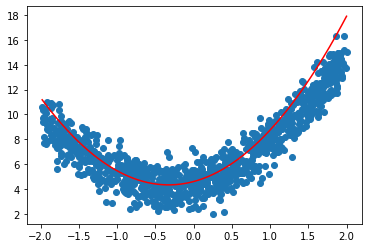

In [37]:
plt.scatter(x_org,y_org)    
# plt.plot(new_x,new_y,color='red')
plt.plot(np.sort(x_org),J_tot_smooth_ab, color = 'red')
# print(J_tot_smooth[1])
# abc = np.sort(J_tot_smooth)
# J_tot_smooth
# x_org

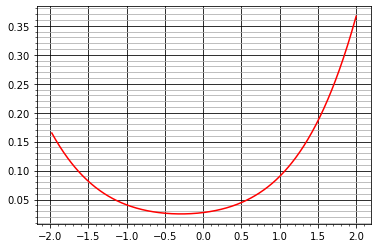

In [38]:
plt.plot(np.sort(x_org),cost_smooth_ab, color = 'red')
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')

In [39]:
# abc = J_tot_smooth
# plt.plot(actual_x[0:10],abc[0:10])

### Fit by stochastic gradient descent
The coefficents we used above are `theta = (4.5678, 1.23456, 2.0)` ...but pretend we don't know that. Let's find the coefficients that minimize squared error by stochastic gradient descent.

In [40]:
def predict(theta, x):
    """
    theta[0] + theta[1] * x + theta[2] * x**2 + ...
    """
    return sum(theta_i * x**i for i, theta_i in enumerate(theta))

In [41]:
def error(theta, x, y):
    return (y - predict(theta, x))

In [42]:
def squared_error(x, y, theta):
    return error(theta, x, y)**2

Using a little calculus, we compute the gradient of the squared error function with respect to the three components of _theta_. The rule we'll apply is:
<div style="margin-left: 60pt; line-height: 6.0; font-size: 120%;">$
\begin{align}
z & = \left(f(x,y)\right)^{n} \\
\frac{\partial z}{\partial x} & = n \cdot \left(f(x,y)\right)^{n-1} \cdot \frac{\partial f}{\partial x}
\end{align}
$</div>

In [43]:
def gradient_squared_error(x, y, theta):
    return [-2 * error(theta, x, y),
            -2 * error(theta, x, y) * x,
            -2 * error(theta, x, y) * x**2]

In [44]:
theta_hat = minimize_stochastic(squared_error, gradient_squared_error, x_org, y_org, theta_0=(1.0, 1.0, 1.0), alpha_0=0.01)
print(theta_hat)

[4.521343060616802, 1.2418182667910478, 2.0007057481909833]


...not a bad job of recovering the coefficients. And the fit to the data looks pretty good.

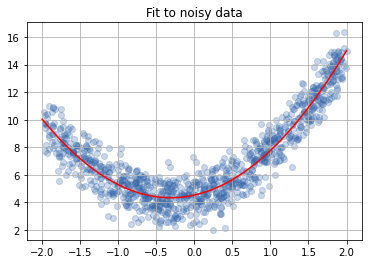

In [45]:
x_ordered = np.linspace(-2, 2, num=n)

plt.scatter(x_org, y_org, marker='o', color='#3366aa40')
plt.plot(x_ordered, predict(theta_hat, x_ordered), 'r-')
plt.title('Fit to noisy data')
plt.grid(True)
plt.show()

In [46]:
z4 = z3.tolist()
# z4[0]
theta_0 = (z4[0][0],z4[0][1],z4[0][2])
beta_tst = minimize_stochastic(squared_error, gradient_squared_error, x_org, y_org, theta_0, alpha_0=0.001)
# # # z4 = z3.tolist()
# # # z4[0][0]
# # print(z4)
# # print(beta_tst)

# # theta_0 = (z4[0][0],z4[0][1],z4[0][2])
# # print(type(theta_0))
beta_tst

print(z4)
print(beta_tst)

[[4.595481319924277, 1.6377628227461816, 2.511482049611036]]
[4.521095440497838, 1.2418895184430943, 2.0007305143809986]


In [47]:
def minimize_stochastic_v2(target_fn, gradient_fn, x, y, theta_list, alpha_0=0.01):
    data = list(zip(x, y))

    # initial guess
    theta = list(theta_list)

    # initial step size
    alpha = alpha_0

    # the minimum so far
    min_theta, min_value = None, float("inf")
    iterations_with_no_improvement = 0
    
    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta[0]) for x_i, y_i in data)

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha *= 0.1
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta[0])
            theta[0] = vector_subtract(theta[0], scalar_multiply(alpha, gradient_i))
            
    return min_theta

In [48]:
z4 = z3.tolist()
# z4[0]
theta_0 = (z4[0][0],z4[0][1],z4[0][2])
# theta_0 = (1,1,1)
beta_tst_1 = minimize_stochastic(squared_error, gradient_squared_error, x_org, y_org, theta_0, alpha_0=0.001)
# # # z4 = z3.tolist()
# # # z4[0][0]
# # print(z4)
# # print(beta_tst)

# # theta_0 = (z4[0][0],z4[0][1],z4[0][2])
# # print(type(theta_0))
beta_tst

print(z4)
print(beta_tst_1)

[[4.595481319924277, 1.6377628227461816, 2.511482049611036]]
[4.521534449143857, 1.2420390645219868, 2.0004931144639064]


In [49]:
beta_tst_2 = minimize_stochastic_v2(squared_error, gradient_squared_error, x_org, y_org, z4, alpha_0=0.001)
beta_tst_2
# iterations_with_no_improvement


[[4.487082285406545, 1.5280713182061703, 2.255555261036759]]

In [50]:
# # def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
# # beta_tst = minimize_stochastic(squared_error, gradient_squared_error, x_org, y_org, theta_0 = (z4[0][0],z4[0][1],z4[0][2]), alpha_0=0.001)
# x = x_org
# y = y_org
# data = list(zip(x, y))

# # initial guess
# theta = list(z4)

# # initial step size
# alpha = 0.01

# # the minimum so far
# min_theta, min_value = None, float("inf")
# iterations_with_no_improvement = 0

# # theta[0]

# # value = np.sum(squared_error(x_i, y_i, theta) for x_i, y_i in data)

# # for x_i,y_i in data:
# # #     print(x_i)
# #     xx = x_i
# #     yy = y_i
# #     err1 = error(theta[0], x_i, y_i)
    

# # theta[0]
# # xx,yy,theta[0]

# for x_i,y_i in data:
#     xx = x_i
#     yy = y_i
#     val = squared_error(x_i,y_i,theta[0])

# val1 = sum(squared_error(x_i, y_i, theta[0]) for x_i, y_i in data)
# val1

# tol = 1e-2
# min_theta_1 = 0
# cnt = 0

# # if we ever go 100 iterations with no improvement, stop
# while tol > alpha**2 and cnt <= 100:
#     value = sum(squared_error(x_i, y_i, theta[0]) for x_i, y_i in data)
#     cnt += 1
# #     print(cnt)

#     if value < min_value:
#         # if we've found a new minimum, remember it
#         # and go back to the original step size
#         min_theta, min_value = theta, value
# #         tol1 = min_theta_1 - min_theta[0][0]
#         tol1 = min_theta_1 - np.sum(min_theta)
#         tol = abs(tol1)
# #         print(tol)
# #         min_theta_1 = min_theta[0][0]
#         min_theta_1 = np.sum(min_theta)
#         iterations_with_no_improvement = 0
#         alpha = 0.01
#     else:
#         # otherwise we're not improving, so try shrinking the step size
#         iterations_with_no_improvement += 1
#         alpha *= 0.9

        
#     # and take a gradient step for each of the data points
#     for x_i, y_i in in_random_order(data):
#         gradient_i = gradient_squared_error(x_i, y_i, theta[0])
#         theta[0] = vector_subtract(theta[0], scalar_multiply(alpha, gradient_i))
        
# #     tol = (min_theta_1 - np.sum(min_theta))
# #     min_theta_1 = min_theta

In [51]:
def minimize_stochastic_v4(target_fn, gradient_fn, x, y, theta_0, max_iter, alpha_0):
# beta_tst = minimize_stochastic(squared_error, gradient_squared_error, x_org, y_org, theta_0 = (z4[0][0],z4[0][1],z4[0][2]), alpha_0=0.001)
#     x = x_org
#     y = y_org
    data = list(zip(x, y))

    # initial guess
    theta = list(theta_0)

    # initial step size
    alpha = alpha_0

    # the minimum so far
    min_theta, min_value = None, float("inf")
    iterations_with_no_improvement = 0

    # theta[0]

    # value = np.sum(squared_error(x_i, y_i, theta) for x_i, y_i in data)

    # for x_i,y_i in data:
    # #     print(x_i)
    #     xx = x_i
    #     yy = y_i
    #     err1 = error(theta[0], x_i, y_i)


    # theta[0]
    # xx,yy,theta[0]

    for x_i,y_i in data:
        xx = x_i
        yy = y_i
        val = target_fn(x_i,y_i,theta[0])

    val1 = sum(target_fn(x_i, y_i, theta[0]) for x_i, y_i in data)
    val1

    tol = 1e-2
    min_theta_1 = 0
    cnt = 0
    
    tol2 = []

    # if we ever go 100 iterations with no improvement, stop
    while tol > alpha**2 and cnt <= max_iter:
        value = sum(target_fn(x_i, y_i, theta[0]) for x_i, y_i in data)
        cnt += 1
    #     print(cnt)

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
    #         tol1 = min_theta_1 - min_theta[0][0]
            tol1 = min_theta_1 - np.sum(min_theta)
            tol = abs(tol1)
    #         print(tol)
    #         min_theta_1 = min_theta[0][0]
            min_theta_1 = np.sum(min_theta)
            iterations_with_no_improvement = 0
            alpha = 0.01
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9


        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta[0])
            theta[0] = vector_subtract(theta[0], scalar_multiply(alpha, gradient_i))

        tol1 = (min_theta_1 - np.sum(min_theta))
        tol2.append(tol1)
#         min_theta_1 = np.sum(min_theta)
        
    return min_theta,cnt,tol2

In [52]:
# max_iter = 200
# alpha_0 = 0.001
# total_cnt = []
# min_theta_b = []
# tolb = []
# cnt0 = max_iter + 1
# # print(cnt0)
# for i in range(3):
#     min_theta_a,cnt, tola = minimize_stochastic_v4(squared_error, gradient_squared_error, x_org, y_org, z4, max_iter,alpha_0)
#     if cnt0 == cnt:
#         min_theta_a,cnt, tola = minimize_stochastic_v4(squared_error, gradient_squared_error, x_org, y_org, z4, max_iter,alpha_0)
# #         print("Theta: ", min_theta_a)
#         print("Count: ", cnt)
# #         cnt0 = cnt
#     total_cnt.append(cnt)
#     min_theta_b.append(min_theta_a)
#     tolb.append(tola)
# min_theta_2 = min_theta_b[total_cnt.index(min(total_cnt))]
# tol1 = tolb[total_cnt.index(min(total_cnt))]

In [53]:
# max_iter = 200
# alpha_0 = 0.01
# total_cnt = []
# min_theta_b = []
# tolb = []
# cnt0 = max_iter + 1
# print(cnt0)
# iter = 0

# min_theta_a,cnt, tola = minimize_stochastic_v4(squared_error, gradient_squared_error, x_org, y_org, z4, max_iter,alpha_0)
# # if cnt0 == cnt:
# while cnt0 == cnt:
#     iter += 1
#     print(iter)
#     min_theta_a,cnt, tola = minimize_stochastic_v4(squared_error, gradient_squared_error, x_org, y_org, z4, max_iter,alpha_0)
#     print(cnt)
#     alpha_0 *= 0.9
# #     print(min_theta_a)
# #     print(tola)
# #     cnt0 = cnt
#     if cnt0 != cnt:
#         min_theta_2 = min_theta_a
# #         print(min_theta_a)
#         tol1 = tola
# #         print(tola)
#         break
#     cnt0 = cnt
        
# # total_cnt.append(cnt)
# # min_theta_b.append(min_theta_a)
# # tolb.append(tola)
# # min_theta_2 = min_theta_b[total_cnt.index(min(total_cnt))]
# # tol1 = tolb[total_cnt.index(min(total_cnt))]
# print(cnt)

In [54]:
max_iter = 500
alpha_0 = 0.001
total_cnt = []
min_theta_b = []
tolb = []
cnt0 = max_iter + 1
# print(cnt0)
i = 0
iter = 0
while i < 1 and iter <= 20:
    i += 1
    iter += 1
    print("Iterations: ", iter)
    min_theta_a,cnt, tola = minimize_stochastic_v4(squared_error, gradient_squared_error, x_org, y_org, z4, max_iter,alpha_0)
    if cnt0 == cnt:
        i = i -1
        min_theta_a,cnt, tola = minimize_stochastic_v4(squared_error, gradient_squared_error, x_org, y_org, z4, max_iter,alpha_0)
#         print("Theta: ", min_theta_a)
#         print("Count: ", cnt)
#         cnt0 = cnt
    total_cnt.append(cnt)
    min_theta_b.append(min_theta_a)
    tolb.append(tola)
#     i += 1
min_theta_2 = min_theta_b[total_cnt.index(min(total_cnt))]
tol1 = tolb[total_cnt.index(min(total_cnt))]

min_theta_2

Iterations:  1


[[4.538068629656367, 1.273184175937994, 1.918036319161563]]

In [55]:
print(total_cnt)
# print(min_theta_b)
# print(tol1)
print(min_theta_2)
# tol1
min_theta_b

[45]
[[4.538068629656367, 1.273184175937994, 1.918036319161563]]


[[[4.538068629656367, 1.273184175937994, 1.918036319161563]]]

In [56]:
print(z4)
print(beta_tst_1)
print(beta_tst_2)
print(min_theta_2)


[[4.595481319924277, 1.6377628227461816, 2.511482049611036]]
[4.521534449143857, 1.2420390645219868, 2.0004931144639064]
[[4.487082285406545, 1.5280713182061703, 2.255555261036759]]
[[4.538068629656367, 1.273184175937994, 1.918036319161563]]


In [57]:
cnt_final = np.min(total_cnt)
tol1
print("Number of Iterations: ", cnt_final)


Number of Iterations:  45


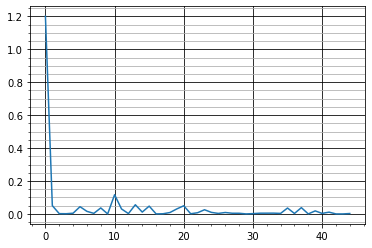

In [58]:
plt.plot(list(range(0,cnt_final)),np.square(tol1))
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')

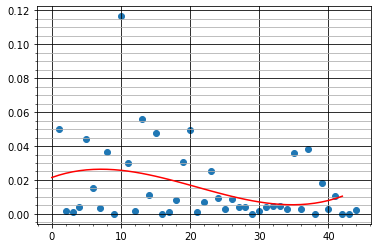

In [59]:
# Matrix Size: Degree of Polynomial
poly_deg = 3
mat_size = poly_deg + 1

# Create dummy matrix
a = np.ones((mat_size,mat_size))
b = np.ones((mat_size,1))

# reserve_factor = 0.1
# reserve = math.ceil(reserve_factor*cnt)

actual_x = list(range(0,cnt_final))
x = list(range(1,cnt_final))
y0 = np.square(tol1)
y = y0[1:]

# Normalize input array
# Mean
meanX = np.mean(x, axis=0)
# meanY = np.mean(y_Jan, axis=0)
# Standard Deviation
stdX = np.std(x, axis = 0)
x = (x- meanX) / stdX
# Variance
varX = np.var(y)
meanY = np.mean(y)
stdY = np.std(y)
# print(x)

# Create design matrix
for i in range(0,mat_size):
    for j in range(0,mat_size):
        a[i][j] = sum(np.power(x,(i+j)))

# Create matrix
amat = np.mat(a)

# print(a)
# print(a[0][0])

# Create design output
for k in range(0, mat_size):
    b[k] = sum(np.power(x,k) * y)
    
# Calculate coefficients
# Inverse input matrix
amat_inv = np.linalg.pinv(amat)
z = amat_inv * b
# Transpose coefficient vector
zz = z.T
# Reverse index list
z3 = zz[::-1]
# print("z3: ", zz)

# print(len(x))
# print(len(y))

# # Create dummy array
# J = np.ones((len(x), 1))
# cost = np.ones((len(x),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x))):
#     for p in range(0, mat_size):
#         vec_out[p] = x[q] ** p
#     # Algebraic vector
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(z3,vec_out)
#     J[q] = np.sum(l)
#     # Cost Function
#     cost[q] = (1/(2 * len(x))) * np.sum(np.square(J[q] - vec_out))

# Create vector of input terms
# x_list = actual_x
# x = x_list
# # Normalization
# x = (x - meanX) / stdX

x1 = np.sort(x)
J_tot_smooth = np.ones((len(y), 1))
cost_smooth = np.ones((len(y),1))
vec_out = np.ones((mat_size, 1))
# Solve for predicted values
for q in (range(len(x))):
    for p in range(0, mat_size):
        vec_out[p] = x1[q] ** p
    # Alebraic terms
    vec_out = np.matrix(vec_out)
    # Matrix multiplication
    l = np.matmul(z3,vec_out)
    # Solve to create smoothen curve
    J_tot_smooth[q] = (l)
    # Cost function
    cost_smooth[q] = np.multiply((1/(2 * len(x1))),np.sum(np.square(J_tot_smooth[q] - vec_out)))



lists = sorted(zip(*[x_org, J_tot_smooth]))
new_x, new_y = list(zip(*lists))

J_tot_smooth_a = np.vstack((y0[0],J_tot_smooth))

    
plt.scatter(actual_x[1:],y0[1:])    
# plt.plot(new_x,new_y,color='red')
plt.plot(J_tot_smooth[1:], color = 'red')
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')
# print(J_tot_smooth[1])
# abc = np.sort(J_tot_smooth)
# J_tot_smooth
# x_org

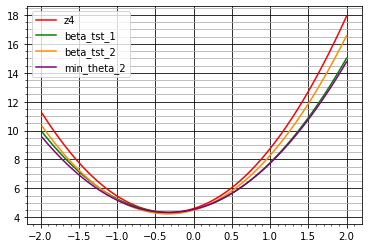

In [60]:
x1 = np.sort(x_org)
y = y_org

# mat_size = mat_size - 1
poly_deg -= 1


# J_tot_smooth = np.ones((len(x1), 1))
# cost_smooth = np.ones((len(x1),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x1))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(z4,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth[q] = (l)
#     # Cost function
#     cost_smooth[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth[q] - vec_out))
    
J_tot_smooth, cost_smooth = poly_line(x1,y,poly_deg,z4[0])
    
# J_tot_smooth_2 = np.ones((len(x1), 1))
# cost_smooth_2 = np.ones((len(x1),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x1))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(beta_tst_1,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_2[q] = (l)
#     # Cost function
#     cost_smooth_2[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth_2[q] - vec_out))

J_tot_smooth_2, cost_smooth_2 = poly_line(x1,y,poly_deg,beta_tst_1)

# J_tot_smooth_3 = np.ones((len(x1), 1))
# cost_smooth_3 = np.ones((len(x1),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x1))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(beta_tst_2,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_3[q] = (l)
#     # Cost function
#     cost_smooth_3[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth_3[q] - vec_out))

J_tot_smooth_3, cost_smooth_3 = poly_line(x_org,y_org,poly_deg,beta_tst_2)
    
# J_tot_smooth_4 = np.ones((len(x1), 1))
# cost_smooth_4 = np.ones((len(x1),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x1))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(min_theta_2,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_4[q] = (l)
#     # Cost function
#     cost_smooth_4[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth_4[q] - vec_out))

J_tot_smooth_4, cost_smooth_4 = poly_line(x_org,y_org,poly_deg,min_theta_2)



# lists = sorted(zip(*[x_org, J_tot_smooth]))
# new_x, new_y = list(zip(*lists))

    
# plt.scatter(x_org,y_org)    
# plt.plot(new_x,new_y,color='red')
# plt.plot(np.sort(x_org),J_tot_smooth, np.sort(x_org),J_tot_smooth_2)
plt.plot(np.sort(x_org),J_tot_smooth, color='red')
plt.plot(np.sort(x_org),J_tot_smooth_2, color = 'green')
plt.plot(np.sort(x_org),J_tot_smooth_3, color = 'darkorange')
plt.plot(np.sort(x_org),J_tot_smooth_4, color = 'purple')
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')
plt.legend(['z4','beta_tst_1','beta_tst_2', 'min_theta_2'])
# print(J_tot_smooth[1])
# abc = np.sort(J_tot_smooth)
# J_tot_smooth
# x_org



In [61]:
# x1 = np.sort(x_org)

# J_tot_smooth = np.ones((len(y), 1))
# cost_smooth = np.ones((len(y),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(z4,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth[q] = (l)
#     # Cost function
#     cost_smooth[q] = np.sqrt((1/(2 * len(x))) * np.sum(np.square(J_tot_smooth[q] - vec_out)))

    
# J_tot_smooth_2 = np.ones((len(y), 1))
# cost_smooth_2 = np.ones((len(y),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(beta_tst_1,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_2[q] = (l)
#     # Cost function
#     cost_smooth_2[q] = np.sqrt((1/(2 * len(x))) * np.sum(np.square(J_tot_smooth_2[q] - vec_out)))

# J_tot_smooth_3 = np.ones((len(y), 1))
# cost_smooth_3 = np.ones((len(y),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(beta_tst_2,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_3[q] = (l)
#     # Cost function
#     cost_smooth_3[q] = np.sqrt((1/(2 * len(x))) * np.sum(np.square(J_tot_smooth_3[q] - vec_out)))
    
# J_tot_smooth_4 = np.ones((len(y), 1))
# cost_smooth_4 = np.ones((len(y),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(min_theta_2,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_4[q] = (l)
#     # Cost function
#     cost_smooth_4[q] = np.sqrt((1/(2 * len(x))) * np.sum(np.square(J_tot_smooth_4[q] - vec_out)))



# # lists = sorted(zip(*[x_org, J_tot_smooth]))
# # new_x, new_y = list(zip(*lists))

    
# # plt.scatter(x_org,y_org)    
# # plt.plot(new_x,new_y,color='red')
# # plt.plot(np.sort(x_org),J_tot_smooth, np.sort(x_org),J_tot_smooth_2)
# plt.plot(np.sort(x_org),J_tot_smooth, color='red')
# plt.plot(np.sort(x_org),J_tot_smooth_2, color = 'green')
# plt.plot(np.sort(x_org),J_tot_smooth_3, color = 'darkorange')
# plt.plot(np.sort(x_org),J_tot_smooth_4, color = 'purple')
# plt.grid(True, 'major', color='k')
# plt.minorticks_on()
# plt.grid(True, 'minor', 'y')
# plt.legend(['z4','beta_tst_1','beta_tst_2', 'min_theta_2'])
# # print(J_tot_smooth[1])
# # abc = np.sort(J_tot_smooth)
# # J_tot_smooth
# # x_org



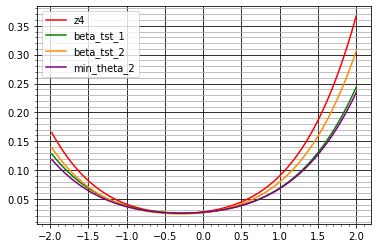

In [62]:
plt.plot(np.sort(x_org),cost_smooth, color='red')
plt.plot(np.sort(x_org),cost_smooth_2, color = 'green')
plt.plot(np.sort(x_org),cost_smooth_3, color = 'darkorange')
plt.plot(np.sort(x_org),cost_smooth_4, color = 'purple')
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')
plt.legend(['z4','beta_tst_1','beta_tst_2', 'min_theta_2'])

3
Tolerance:  1041.990288294082
Differance:  0.0


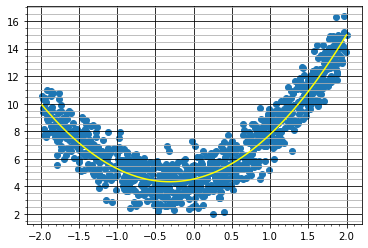

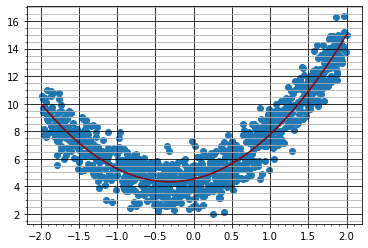

4.462687311402905
4.462687311402904
<class 'list'>
[0, 1, 2]
[16691.6646083678, 2.2373569663614035e-10, 0.0]
[4.521201038487261, 1.241860038955152, 2.0005905398229324]


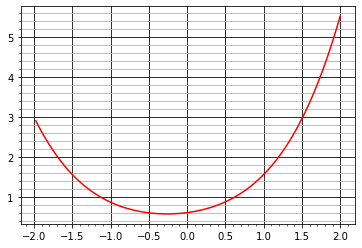

In [63]:
# Create Input & Output arrays

# Create output values
y = y_org

# Create input values
# t = np.sort(x_org)
t = x_org
# actual_x = x

#%%
# Setup Data

# # Input
# t = [1,2,4,5,8]
# # Output
# y = [3.2939, 4.2699, 7.1749, 9.3008, 20.259]
# # Input
# t = [1,2,4,5,8]
# # t = [1, 2,4,5,8,4.1]
# t = np.array(t)
# # Output
# y = [3.2939, 4.2699, 7.1749, 9.3008, 20.259]
# # y = [3,4,6,11,20,46]
# y = np.array(y)

# New Values
# Noise
# NOISE = 3
# Coefficients
# coeffs = [-0.001, 0.1, 0.1, 2, 15]

# Setup Input
# t = np.arange(1,100)
# coefficients = coeffs[0] * t ** 3 + coeffs[1] * t ** 2 + coeffs[2] * t + coeffs[3] + 1 * np.sin(t)
# coefficients = coeffs[0] * t ** 3 + coeffs[1] * t ** 2 + coeffs[2] * t + coeffs[3]
# Output Values
# y = coefficients + NOISE * np.random.randn(len(t))

# init_guess = 1000000 * np.random.random(len(coefficients))
# print(init_guess)

# Normalize input array
# Mean
meanX = np.mean(t, axis=0)
# print("Mean: ", meanX)
# meanY = np.mean(y_Jan, axis=0)
# Standard Deviation
stdX = np.std(t, axis = 0)
# print("Std Dev: ", stdX)
# t = (t- meanX) / stdX
# Variance
varY = np.var(y)
# print("Variance: ", varY)
# Array lengths
leng = len(t)
#%%
# Initial Guesses
# guess_cnt = 0.01
x1 = 1.5
x2 = 1.5
x3 = 1.1
x4 = 1.08
x_coeff = [x3,x2,x1]
# x5 = 1.0 * guess_cnt
lambda1 = 0.01
# Tolerance
tol = 1e-1
tolerance = []
# Iterations
iter = 0
iterations = []
# iterations.append(iter)
# Coefficients
coeff = []
# Error
err_1 = []
err_0 = []
diff = 0
diff_lst = []

while tol > 1e-8 and iter < 20:
    # Number of iterations
    iterations.append(iter)
    iter = iter + 1
    # iterations.append(iter)

    # Initial Guess
    # Test
    Y_test_0 = []
    for i in range(0, leng):
        y0 = x1 * t[i] ** 2 + x2 * t[i] + x3
        Y_test_0.append(y0)

    # Error
    Y_err_0 = np.array(y) - np.array(Y_test_0)
    err0 = np.dot(Y_err_0, Y_err_0)
    err_0.append(err0)

    # len_0 = Y_err_0.shape
    # print(len_0)

#     print("Error", Y_err_0)

    #%%
    # Setup Equations

    # Intialize Array
    F = []

#     # Vector valued function
#     for i in range(0,leng):
#         # f = (x1 * math.exp(x2 * t[i])) - y[i]
#         f = (x1 * t[i] ** 2 + x2 * t[i] ** 1 + x3 + (0 * np.sin(t[i]))) - y[i]
#         # f = (x1 * t[i] ** 3 + x2 * t[i] ** 2 + x3 * t[i] + x4 ) - y[i]
#         F.append(f)

    vec_out = np.ones((len(x_coeff), 1))
#     F1 = []
    for i in range(0, leng):
        for p in range(0, len(x_coeff)):
            vec_out[p] = t[i] ** p
         # Algebraic vector
        vec_out = np.matrix(vec_out)
    # Matrix multiplication
        l = np.matmul(x_coeff,vec_out) - y[i]
        F.append(l)
       
        
    # Convert to Array
    F = np.array(F)
    F = np.matrix(F)

    # print(F.T)

    # # Hessian
    # # Initialize matrix
    # mat_1 = np.ones((4,leng))
    mat_1 = np.ones((3,leng))

    # First Row
    for i in range(0,leng):
        mat_1[0][i] = t[i] ** 2
    # Second Row
    for i in range(0,leng):
        mat_1[1][i] = t[i] ** 1
    # Third Row
    # for i in range(0,leng):
    #     mat_1[2][i] = t[i]
    # Fourth Row: all "ones"
    # Fifth Row
    # for i in range(0,leng):
    #     mat_1[4][i] = np.sin(t[i])


    # print(mat_1.T)

    #%%
    # Calculations

    F_delta = np.matmul(F,mat_1.T)

    # # Gradient
    F_delta_1 = np.matmul(mat_1, mat_1.T)
    # print(F_delta_1)

    # Solve coefficients p
    # Gradient inverse
    F_delta_1_inv = np.linalg.pinv(F_delta_1)

    # Levenberg-Marquardt
    F_delta_2 = F_delta_1 + lambda1 * lambda1 * np.identity(3)

    #%%
    # Solve coefficients p
    # Gradient inverse
    # F_delta_1_inv = np.linalg.pinv(F_delta_1)
    F_delta_2_inv = np.linalg.pinv(F_delta_2)
    # mat_2_inv = np.linalg.pinv(mat_2 + k_4)

    # Solve for p
    # p = np.matmul(-F_delta, F_delta_1_inv)
    p = np.matmul(-F_delta, F_delta_2_inv)
#     print("P:", p)

    # Convert to list
    p_list = p.tolist()
    p_list = p_list[0]
    coeff.append(p_list[0])

    # Update guesses
    x1 = x1 + p_list[0]
    x2 = x2 + p_list[1]
    x3 = x3 + p_list[2]
    # x4 = x4 + p_list[3]
    # x5 = x5 + p_list[4]
    x_coeff = [x3,x2,x1]

    # pp = p.tolist()
    # ppp3 = pp[0]
    # print(type(pp))
    # print(ppp3[0])
    # Calculate new tolerance
    # tol = abs(p_list[0])
    tol = (np.sum(F_delta))
#     tol = np.square(tol1)
    # print("Tolerance: ", tol)

    Y_test_1 = []
    for i in range(0,leng):
    # f = (x1 * math.exp(x2 * t[i])) - y[i]
        f = (x1 * t[i] ** 2) + x2 * t[i] + x3
    # f = (x1 * t[i] ** 3 + x2 * t[i] ** 2 + x3 * t[i] + x4 ) - y[i]
        Y_test_1.append(f)
        
    vec_out = np.ones((3, 1))
    Y_test_2 = []
    cost_smooth_5 = []
    for i in range(0, leng):
        for p in range(0, len(x_coeff)):
            vec_out[p] = t[i] ** p
         # Algebraic vector
        vec_out = np.array(vec_out)
    # Matrix multiplication
        l = np.dot(x_coeff,vec_out)
        Y_test_2.append(l)
    # Cost function
        cost_smooth_5.append((1/(2 * len(x))) * np.sum(np.square(l - vec_out)))


    # Error
    # Y_err_1 = np.array(y) - np.array(Y_test_1)
    # err1 = np.dot(Y_err_1, Y_err_1)
    # err_1.append(err1)

    # Error
#     Y_err_1 = np.array(y) - np.array(Y_test_1)
    Y_err_1 = []
    for i in range(leng):
        y_diff = y[i] - Y_test_2[i][0]
        Y_err_1.append(y_diff)
    Y_err_1 = np.array(Y_err_1)
    Y_err_1_sq = np.square(Y_err_1)
    sse = np.sum(Y_err_1_sq)
    tol = sse
    err1 = np.dot(Y_err_1, Y_err_1)
    err_1.append(err1)
    tolerance.append(tol)

    if err1 < err0:
        lambda1 = lambda1 / 10
    else:
        lambda1 = lambda1 * 10

    # Difference in errors
    diff = abs(err1 - err0)
    diff_lst.append(diff)
    if diff < 1e-20:
#         iter += 1
#         iterations.append(iter)
        break

    # i = 1e-1
    # while i > 1e-5:
    #     iter += 1
    #     # print(i)
    #     i -= 0.0005

    # print(iter)
    # print("P:", p_list)

# Y = []
# tt = list(range(0,324))
# for i in range(0, 324):
#     # y0 = x1 * np.exp(x2 * t[i])
#     y0 = (x1 * (tt[i] ** 2)) + (x2 * (tt[i] ** 1)) + x3
#     # y0 = (x1 * (t[i] ** 3)) + (x2 * (t[i] ** 2)) + (x3 * t[i]) + x4
#     y1 = np.sum(np.random.randn(4)) * (varY ** 2) + y0
#     # y1 = y0 * (varY ** 2) + meanX
#     Y.append(y1)

# print(Y)
# print(coeff)
print(iter)
print("Tolerance: ", tol)
print("Differance: ", diff)

# Random Number
# print(np.random.randn(1))

#%%
# Plots

lists = sorted(zip(*[x_org, Y_test_1]))
new_x, new_y = list(zip(*lists))

lists_cost = sorted(zip(*[x_org, cost_smooth_5]))
x_cost, y_cost = list(zip(*lists_cost))

yy = np.sort(Y_test_1)
# print(yy)

plot1 = plt.figure(1)
plt.scatter(x_org,y_org)
# plt.plot(np.sort(x_org),(Y_test_1), color='darkorange')
plt.plot(new_x,new_y, color = 'yellow')
# plt.plot(sorted(x_org),yy)
# plt.plot(tt,Y, 'r')
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')

# plot2 = plt.figure(2)
# plt.plot(list(range(1,len(tolerance))), tolerance[0:len(tolerance)-1])
# plt.grid()


# sorted(x_org)
new_y
abc = sorted(zip(x_org,Y_test_1))
abcd = list(abc)
xs = []
ys = []
for i in range(len(abcd)):
    xs.append(abcd[i][0])
    ys.append(abcd[i][1])

plot3 = plt.figure(3)
plt.scatter(x_org,y_org)
plt.plot(xs, ys, color = 'darkred')
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')

# Show plots
plt.show()

x_nlls = [x3,x2,x1]
x_nlls

print(Y_test_1[leng-1])
print(Y_test_2[leng-1][0])
print(type(Y_test_2))
# Y_test_1[0][1]
print(iterations)
print(diff_lst)
# print(cost_smooth_5)
print(x_nlls)

plt.plot(x_cost,y_cost, color='red')
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')


In [64]:
# x1 = np.sort(x_org)
# y = y_org

# mat_size = mat_size - 1

# J_tot_smooth = np.ones((len(x_org), 1))
# cost_smooth = np.ones((len(x_org),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x_org))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(z4,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth[q] = (l)
#     # Cost function
#     cost_smooth[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth[q] - vec_out))

# J_tot_smooth_2 = np.ones((len(x_org), 1))
# cost_smooth = np.ones((len(x_org),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x_org))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(beta_tst_1,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_2[q] = (l)
#     # Cost function
#     cost_smooth[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth[q] - vec_out))
    
# J_tot_smooth_3 = np.ones((len(x_org), 1))
# cost_smooth = np.ones((len(x_org),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x_org))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(beta_tst_2,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_3[q] = (l)
#     # Cost function
#     cost_smooth[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth[q] - vec_out))

# J_tot_smooth_4 = np.ones((len(y_org), 1))
# cost_smooth = np.ones((len(y_org),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x_org))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(min_theta_2,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_4[q] = (l)
#     # Cost function
#     cost_smooth[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth[q] - vec_out))



# lists = sorted(zip(*[x_org, Y_test_1]))
# new_x, new_y = list(zip(*lists))

    
# plt.scatter(x_org,y_org, color = 'lightblue')    
# # plt.plot(new_x,new_y,color='red')
# # plt.plot(np.sort(x_org),J_tot_smooth, np.sort(x_org),J_tot_smooth_2)
# plt.plot(np.sort(x_org),J_tot_smooth, color='red')
# plt.plot(np.sort(x_org),J_tot_smooth_2, color = 'yellow')
# plt.plot(np.sort(x_org),J_tot_smooth_3, color = 'darkorange')
# plt.plot(np.sort(x_org),J_tot_smooth_4, color = 'magenta')
# # plt.plot(np.sort(x_org),J_tot_smooth_4, color = 'purple')
# plt.plot(new_x,new_y, color = 'lime')
# plt.grid(True, 'major', color='k')
# plt.minorticks_on()
# plt.grid(True, 'minor', 'y')
# plt.legend(['z4','beta_tst_1','beta_tst_2', 'min_theta','nlls'])

# # print(J_tot_smooth[1])
# # abc = np.sort(J_tot_smooth)
# # J_tot_smooth
# # x_org

In [65]:
z4

[[4.595481319924277, 1.6377628227461816, 2.511482049611036]]

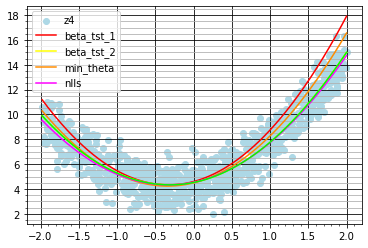

In [66]:
# J_tot_smooth_ab, cost_smooth_ab = poly_line(x_org,y_org,poly_deg,z3)

x1 = np.sort(x_org)
y = y_org

mat_size = mat_size - 1
poly_deg = 2

# J_tot_smooth = np.ones((len(x_org), 1))
# cost_smooth = np.ones((len(x_org),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x_org))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(z4,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth[q] = (l)
#     # Cost function
#     cost_smooth[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth[q] - vec_out))
    
J_tot_smooth, cost_smooth = poly_line(x1,y,poly_deg,z4[0])

# J_tot_smooth_2 = np.ones((len(x_org), 1))
# cost_smooth = np.ones((len(x_org),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x_org))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(beta_tst_1,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_2[q] = (l)
#     # Cost function
#     cost_smooth[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth[q] - vec_out))

J_tot_smooth_2, cost_smooth_2 = poly_line(x1,y,poly_deg,beta_tst_1)
    
# J_tot_smooth_3 = np.ones((len(x_org), 1))
# cost_smooth = np.ones((len(x_org),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x_org))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(beta_tst_2,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_3[q] = (l)
#     # Cost function
#     cost_smooth[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth[q] - vec_out))

J_tot_smooth_3, cost_smooth_3 = poly_line(x1,y,poly_deg,beta_tst_2)

# J_tot_smooth_4 = np.ones((len(y_org), 1))
# cost_smooth = np.ones((len(y_org),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x_org))):
#     for p in range(0, mat_size):
#         vec_out[p] = x1[q] ** p
#     # Alebraic terms
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(min_theta_2,vec_out)
#     # Solve to create smoothen curve
#     J_tot_smooth_4[q] = (l)
#     # Cost function
#     cost_smooth[q] = (1/(2 * len(x))) * np.sum(np.square(J_tot_smooth[q] - vec_out))

J_tot_smooth_4, cost_smooth_4 = poly_line(x1,y,poly_deg,min_theta_2)



lists = sorted(zip(*[x_org, Y_test_1]))
new_x, new_y = list(zip(*lists))

    
plt.scatter(x_org,y_org, color = 'lightblue')    
# plt.plot(new_x,new_y,color='red')
# plt.plot(np.sort(x_org),J_tot_smooth, np.sort(x_org),J_tot_smooth_2)
plt.plot(np.sort(x_org),J_tot_smooth, color='red')
plt.plot(np.sort(x_org),J_tot_smooth_2, color = 'yellow')
plt.plot(np.sort(x_org),J_tot_smooth_3, color = 'darkorange')
plt.plot(np.sort(x_org),J_tot_smooth_4, color = 'magenta')
# plt.plot(np.sort(x_org),J_tot_smooth_4, color = 'purple')
plt.plot(new_x,new_y, color = 'lime')
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')
plt.legend(['z4','beta_tst_1','beta_tst_2', 'min_theta','nlls'])

# print(J_tot_smooth[1])
# abc = np.sort(J_tot_smooth)
# J_tot_smooth
# x_org

In [67]:
print(z4[0])
print(beta_tst_1)
print(beta_tst_2[0])
print(min_theta_2[0])
print(x_nlls)


[4.595481319924277, 1.6377628227461816, 2.511482049611036]
[4.521534449143857, 1.2420390645219868, 2.0004931144639064]
[4.487082285406545, 1.5280713182061703, 2.255555261036759]
[4.538068629656367, 1.273184175937994, 1.918036319161563]
[4.521201038487261, 1.241860038955152, 2.0005905398229324]
